# 4. Statistical Modeling and Analysis

## 4.1 Data collection

### Web Scraping:  Rate My Professor

Since professors play the most crucial part in a course, we decide to collect data referring to students' ratings on them based upon the 2018-Winter courses data we scraped.

__`'Rating My Professors'`__, as the largest online destination for professor ratings, is an appropriate reference for students to figure out who's a great professor and who's the one they might want to avoid. In other words, it is also a perfect sample of which we are able to make use.

Therefore, we chose it to scrap related data. The scraping raw data include an evaluation variable of courses -- "Overall Quality" (value varies from 1 to 5 in float format), an evaluation variable of professors -- "RatingType" (levels vary from 'awful' to 'awesome'), an evaluation variable of efforts students need to put on the course -- "The level of difficulty" (vary from 1 to 5 in integer format, the higher, the more difficult), the courses number, textbook used or not, 3 tags that best describe the professor, and specific comments. Finally, we scraped __$21088$__ raw data.

In [1]:
import pandas as pd
import sqlite3 as sql

from time import sleep
import random

import re

import numpy as np

## 4.2 Data Processing

This part focus on data cleaning. There are missing data shown as $NA$ at the raw data we collected. In the following process, based on the percentage of $NA$ in the data we want to use, most of them have been dropped to deal with this case.

In [2]:
# Create the rate my professor doc
db = sql.connect('data.db')
rmp = pd.read_sql('SELECT * FROM rmp',db)

rmp = rmp.drop(columns=['Attendance','Grade Received','For Credit'])
rmp['department'] = rmp['Class']

# Get the first three abbreviated letters at department
rmp.iloc[:,[-1]] = rmp['department'].str.replace(r"([A-Z]{0,3}).+",r"\1")

# Get the abbreviated name of departments from UC Davis
course_ab_list = pd.read_sql('SELECT * FROM deptabb',db)['Subject_Code'].tolist()

In [3]:
# Check the ratio of those unfittable with course_ab_list
sum([i not in course_ab_list for i in rmp['department']])/rmp.shape[0]

0.04651934749620637

Since the course name part is entered arbitrarily, there exists some typo which made some abbreviated names we separated from the scraping data are inconsistent to the names from UC Davis.

From the above output, we can find out that the inconsistent ones only contain around $4.65$%, for the following work, we decide to drop them.

In [4]:
# Select rows that have explicit departments
rmp =  rmp.loc[[i in course_ab_list for i in rmp['department']],]

Now we select the different course abbreviations and output as a csv.

In [5]:
# List of abbreviate name in the rmp doc
different = list(set(rmp['department'].tolist()))
print('The number of different department-courses is', len(different))

department_different = pd.DataFrame({'department':different})
department_different.to_csv('department_different.csv')

The number of different department-courses is 143


In [6]:
# get the class difficulty level
rmp.iloc[:,[0]] = rmp['Class'].str.replace(r"[A-Z]*\s*([0-9]+)\s*[a-zA-Z]*",r"\1")

In [7]:
# select data that don't contain numbers and hard to distinguish the difficulty of course
sum(rmp['Class'].str.contains(r"[A-Za-z]+"))/rmp.shape[0]

0.007708758143929974

For the same reason, we calculated data that don't contain numbers (typo). From the above output, it only contains around $0.77$%, for the following work, they have been dropped as well.

In [8]:
# Select the rows that have numbers indicating the course difficulty level
rmp = rmp.loc[~rmp['Class'].str.contains(r"[A-Za-z]+"),]
rmp.dtypes

Class                   object
Department              object
Level of Difficulty    float64
Overall Quality        float64
Professor               object
RatingType              object
Textbook Used           object
Would Take Again        object
comment                 object
comment tags            object
date\r\r                object
department              object
dtype: object

In [9]:
# For latter levels separation, we change the type of 'Class' to int64
rmp['Class']= rmp['Class'].astype('int64')

rmp = rmp.reset_index(drop=True)

In [10]:
# Set the difficulty level of courses based on course number
rmp['class'] = np.nan
for i in range(rmp.shape[0]):
    if rmp.Class[i] <100:
        rmp.iloc[i,[-1]] = 0
    elif rmp.Class[i] <130:
        rmp.iloc[i,[-1]] = 1
    else:
        rmp.iloc[i,[-1]] = 2
        
rmp.head()

,Class,Department,Level of Difficulty,Overall Quality,Professor,RatingType,Textbook Used,Would Take Again,comment,comment tags,date,department,class
0,188,the History department,3.0,5.0,Rauchway Eric,awesome,Yes,Yes,"No doubt, Rauchway is a solid lecturer and the...",[''],12/20/2017\r\r,HIS,2.0
1,119,the History department,3.0,4.0,Rauchway Eric,good,Yes,Yes,Teaching a joint course with Prof. Campbell on...,"['BEWARE OF POP QUIZZES', 'RESPECTED', 'AMAZIN...",06/21/2017\r\r,HIS,1.0
2,174,the History department,3.0,2.0,Rauchway Eric,poor,Yes,No,He is unorganized and offers random in-class q...,"['PARTICIPATION MATTERS', 'TOUGH GRADER', ""SKI...",09/30/2016\r\r,HIS,2.0
3,17,the History department,3.0,4.0,Rauchway Eric,good,Yes,Yes,Pretty solid and entertaining lecturer. Howeve...,"['EXTRA CREDIT', 'GRADED BY FEW THINGS', 'GET ...",06/16/2016\r\r,HIS,0.0
4,188,the History department,3.0,4.5,Rauchway Eric,awesome,No,N/A,I really enjoyed the lectures. The books were ...,"['AMAZING LECTURES', 'CLEAR GRADING CRITERIA',...",12/31/2015\r\r,HIS,2.0


In [11]:
# convert RatingType to numbers
rmp['rating'] = np.nan
for i in range(rmp.shape[0]):
    if rmp.RatingType[i] == 'awesome':
        rmp.iloc[i,[-1]] = 4
    elif rmp.RatingType[i] == 'good':
        rmp.iloc[i,[-1]] = 3
    elif rmp.RatingType[i] == 'average':
        rmp.iloc[i,[-1]] =2
    elif rmp.RatingType[i] == 'poor':
        rmp.iloc[i,[-1]] = 1
    else:
        rmp.iloc[i,[-1]] = 0

#### STEM and Not STEM

We consider to divide departments as two groups: __STEM__ and __ART__. Then we denote them as dummy vairable, in which __STEM__ is 0 and __Not STEM__ is 1.

In [12]:
# Read the department division doc
dep_pd = pd.read_sql('SELECT * FROM deptstem',db)
dep_pd.head()

,department,detail,Category
0,PHY,Physics,STEM
1,IST,Integrated Studies,ART
2,NSC,Neuroscience (Graduate Group),STEM
3,PSC,Psychology,STEM
4,PBI,Plant Biology (Graduate Group),STEM


In [13]:
# Get the department list of STEM and ART division
stem_list = dep_pd[dep_pd['Category'] == 'STEM']['department'].tolist()
art_list = dep_pd[dep_pd['Category'] == 'ART']['department'].tolist()

In [14]:
# Select rows that have departments belonging to eith STEM or ART
stem = rmp.loc[rmp['department'].isin(stem_list)]
art = rmp.loc[rmp['department'].isin(art_list)]

In [15]:
# Creat dummy variables: STEM = 0, ART = 1
rmp['dptment'] = np.nan
for i in range(rmp.shape[0]):
    if rmp.department[i] in stem_list:
        rmp.iloc[i,[-1]] = 0
    else:
        rmp.iloc[i,[-1]] = 1
        
rmp.head()

,Class,Department,Level of Difficulty,Overall Quality,Professor,RatingType,Textbook Used,Would Take Again,comment,comment tags,date,department,class,rating,dptment
0,188,the History department,3.0,5.0,Rauchway Eric,awesome,Yes,Yes,"No doubt, Rauchway is a solid lecturer and the...",[''],12/20/2017\r\r,HIS,2.0,4.0,1.0
1,119,the History department,3.0,4.0,Rauchway Eric,good,Yes,Yes,Teaching a joint course with Prof. Campbell on...,"['BEWARE OF POP QUIZZES', 'RESPECTED', 'AMAZIN...",06/21/2017\r\r,HIS,1.0,3.0,1.0
2,174,the History department,3.0,2.0,Rauchway Eric,poor,Yes,No,He is unorganized and offers random in-class q...,"['PARTICIPATION MATTERS', 'TOUGH GRADER', ""SKI...",09/30/2016\r\r,HIS,2.0,1.0,1.0
3,17,the History department,3.0,4.0,Rauchway Eric,good,Yes,Yes,Pretty solid and entertaining lecturer. Howeve...,"['EXTRA CREDIT', 'GRADED BY FEW THINGS', 'GET ...",06/16/2016\r\r,HIS,0.0,3.0,1.0
4,188,the History department,3.0,4.5,Rauchway Eric,awesome,No,N/A,I really enjoyed the lectures. The books were ...,"['AMAZING LECTURES', 'CLEAR GRADING CRITERIA',...",12/31/2015\r\r,HIS,2.0,4.0,1.0


In [16]:
# Choose the revelant variables
rmp_final = rmp[['Department', 'Level of Difficulty', 'Overall Quality', 'Professor', 'RatingType', 'class', 'dptment','rating']]
rmp_final.head()

,Department,Level of Difficulty,Overall Quality,Professor,RatingType,class,dptment,rating
0,the History department,3.0,5.0,Rauchway Eric,awesome,2.0,1.0,4.0
1,the History department,3.0,4.0,Rauchway Eric,good,1.0,1.0,3.0
2,the History department,3.0,2.0,Rauchway Eric,poor,2.0,1.0,1.0
3,the History department,3.0,4.0,Rauchway Eric,good,0.0,1.0,3.0
4,the History department,3.0,4.5,Rauchway Eric,awesome,2.0,1.0,4.0


## 4.3 Exploratory data analysis

In [17]:
# Choose variables for latter regression model

data = rmp_final.iloc[:,[2,1,4,5,6,7]]
data.head()

,Overall Quality,Level of Difficulty,RatingType,class,dptment,rating
0,5.0,3.0,awesome,2.0,1.0,4.0
1,4.0,3.0,good,1.0,1.0,3.0
2,2.0,3.0,poor,2.0,1.0,1.0
3,4.0,3.0,good,0.0,1.0,3.0
4,4.5,3.0,awesome,2.0,1.0,4.0


### 4.3.1 Exploring the response variable

 First we try to investigate the distribiton of Overall Quality (Y):

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

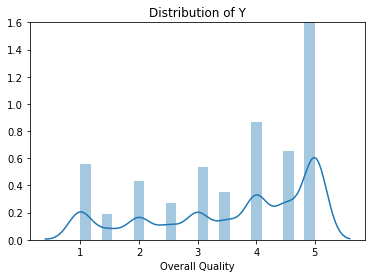

In [19]:
plot = sns.distplot(data['Overall Quality'])
plot.set(title = "Distribution of Y")
plot.set_ylim(0,1.6) 
plt.show()

From the above distribution plot, we can recognize that Y is not very normally distributed. In this situation, we consider a frequently used transformation method - Box-Cox transformation to try to figure out a better form of Y.

### box-cox transformation: 

In [20]:
from scipy import stats
import numpy as np
import math

In [21]:
lmbda = stats.boxcox_normmax(data['Overall Quality'])
Y_t = (data['Overall Quality']**lmbda - 1) / lmbda
lmbda

1.8047110571445677

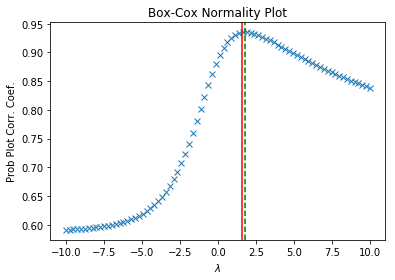

In [22]:
y, lmax_mle = stats.boxcox(data['Overall Quality'])
lmax_pearsonr = stats.boxcox_normmax(data['Overall Quality'])

fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(data['Overall Quality'], -10, 10, plot=ax)
ax.axvline(lmax_mle, color='r')
ax.axvline(lmax_pearsonr, color='g', ls='--')

plt.show()

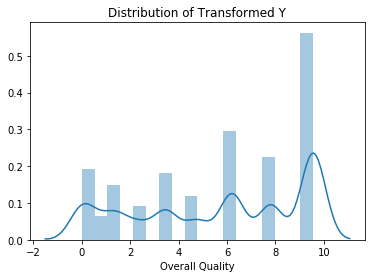

In [23]:
plot = sns.distplot(Y_t)
plot.set(title = "Distribution of Transformed Y")
plt.show()

According to the Box-Box transformation, the normality achives its maximum when $\lambda=1.8$. However, the distribution plot of transformed Y doesn't shows a better normal pattern. 

Still, this result well coincides the Box-Cox normality plot, because the normality when $\lambda=1$ is only slightly less than that of the maximized $\lambda$.In consideration of the interpretability of the model fitted later, we decide to keep the original form of Y, that is, we don't do any transformation of the response variable.

### 4.3.2 Preliminary investigations of Predictor variables

Then we explore the relations between variables. Since only Overall Quality and Level of difficulty are quantitative variables, we use a correlogram to look at their relations. And in observation of  extremely huge sample size as well as the severe superposition in values, we choose the first 100 data so that relations are not submerged by the amount of data.

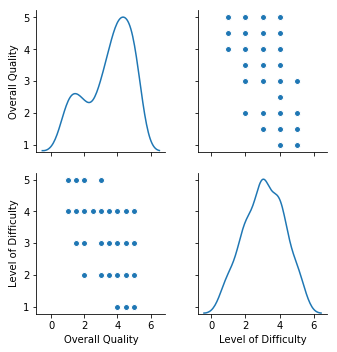

In [24]:
plot = sns.pairplot(data[:100].iloc[:,[0,1]], diag_kind="kde")
plt.show()

The correlation plot implies that there may be a linear or onlinear relation between Overall Quality and Level of difficulty, and they are negatively correlated, which can be explained as an easier course can get a higher rating in average.

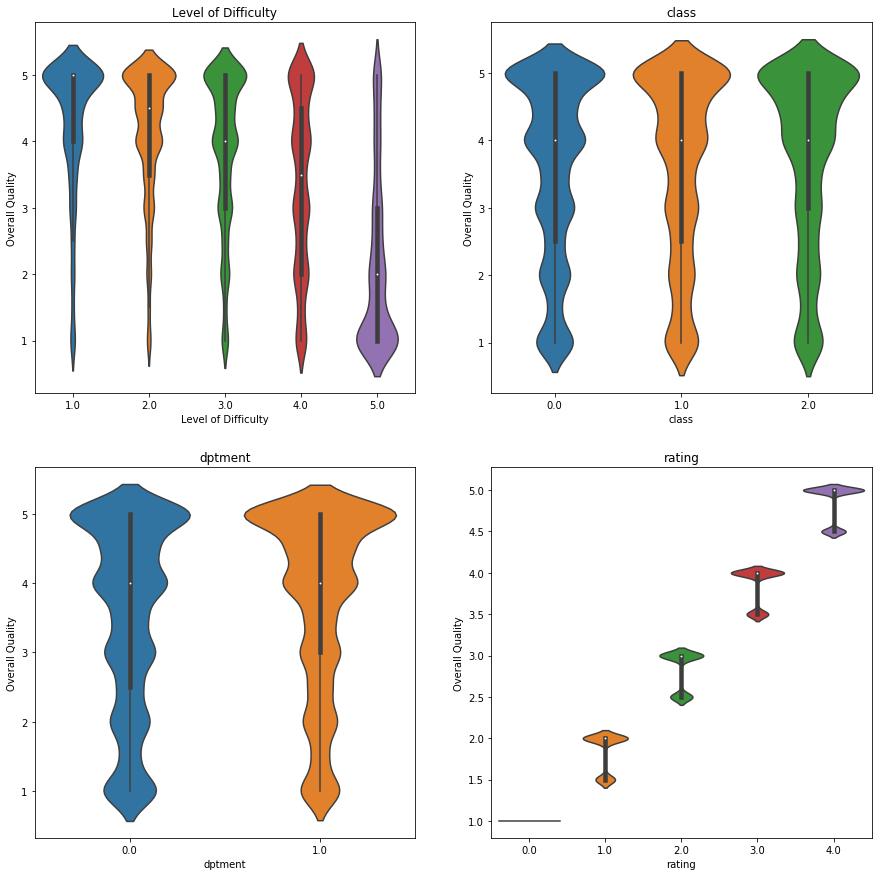

In [38]:
# violin plot to check the distribution of qualitative variables

f, axes = plt.subplots(2, 2, figsize=(15,15))
buckets = ['Level of Difficulty', 'class', 'dptment', 'rating']

for i in buckets:
    df = data[["Overall Quality",i]]
    row = buckets.index(i) // 2
    col = buckets.index(i) % 2
    ax_curr = axes[row, col]
    sns.violinplot(x=i, y="Overall Quality", data=df, ax=ax_curr)
    ax_curr.set_title(i)

plt.show()

* From the above violin plots, the distribution of response variable __"Overall Quality"__ within each class of the predictor variable __"Level of Difficulty"__ shows __Overall Quality__ becomes lower as __the level of difficulty__ goes up. Especially for the most difficult courses, the overall quality is centered around 1, which presents the strong negative impact on overall quality when the difficulty of course is very high.

* The distribution of __Overall Quality__ states no obvious difference among __the level of class__, no difference between __STEM and Not-STEM courses__ as well.

* The linear relationship between __Overall Quality__ (for courses) and __rating__ (for professors) is very clear. This confirms the prior conclusion that professors play a crucial part in courses.

#### Reference: Box-Cox transformation
http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html

https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781785282287/4/ch04lvl1sec56/normalizing-with-the-box-cox-transformation

## 4.4 Multiple Linear Regression

We recode them with X and Y's. And since we take Overall Quality as our response variable, we code it as Y:

$Y$: Overall Quality.

The rest are X variables, among which Overall Quality is a quantitative variable, while others are qualitative variables. We take the qualitative ones as factors and use dummy variables to code them:

$X_1$: Level of Difficulty

$X_{21}=
\left\{\begin{array}{cc} 
		1,RatingType=average\\
		0,RatingType=poor 
	\end{array}\right.$
$X_{22}=
\left\{\begin{array}{cc} 
		1,RatingType=awesome\\
		0,RatingType=poor 
	\end{array}\right.$
$X_{23}=
\left\{\begin{array}{cc} 
		1,RatingType=aweful\\
		0,RatingType=poor 
	\end{array}\right.$    
$X_{24}=
\left\{\begin{array}{cc} 
		1,RatingType=good\\
		0,RatingType=poor 
	\end{array}\right.$

$X_{31} = 
\left\{\begin{array}{cc} 
		1,class=1(level:100-129)\\
		0,class=0(level:0-99) 
	\end{array}\right.$
$X_{32} = 
\left\{\begin{array}{cc} 
		1, class=2(level:130-)\\
		0,class=0(level:0-99)
	\end{array}\right.$
$X_4 = 
\left\{\begin{array}{cc} 
		1, department=1(nonSTEM)\\
		0,department=0(STEM)
	\end{array}\right.$

In [25]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

C:\Users\Administrator\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [26]:
# Choose variables for regression
data = rmp_final.iloc[:,[2,1,4,5,6]]
data.head()

,Overall Quality,Level of Difficulty,RatingType,class,dptment
0,5.0,3.0,awesome,2.0,1.0
1,4.0,3.0,good,1.0,1.0
2,2.0,3.0,poor,2.0,1.0
3,4.0,3.0,good,0.0,1.0
4,4.5,3.0,awesome,2.0,1.0


In [27]:
# Make dummy variables for class and department
dummy1 = pd.get_dummies(data['RatingType'])
dummy2 = pd.get_dummies(data['class'])
dummy3 = pd.get_dummies(data['dptment'])

In [28]:
# Reschedule the dataset
data = pd.concat([data, dummy1,dummy2,dummy3], axis=1)
data = data.iloc[:,[0,1,5,6,7,8,11,12,14]]
data.columns = ['Y','X1','X21','X22','X23','X24','X31','X32','X4']
data.head()

,Y,X1,X21,X22,X23,X24,X31,X32,X4
0,5.0,3.0,0,1,0,0,0,1,1
1,4.0,3.0,0,0,0,1,1,0,1
2,2.0,3.0,0,0,0,0,0,1,1
3,4.0,3.0,0,0,0,1,0,0,1
4,4.5,3.0,0,1,0,0,0,1,1


During model establishment, we first consider a full model, where we include all the first-order terms, the quadratic term of $X_1$ and the interaction between $X_1$ and $X_4$:

$Y=\beta_0+\beta_1X_1+\beta_{21}X_{21}+\beta_{22}X_{22}++\beta_{23}X_{23}++\beta_{24}X_{24}+\beta_{32}X_{31}++\beta_{32}X_{32}+\beta_4X_4+\beta_5X_1^2+\beta_6X_1X_4+\epsilon$

### Model Selection

In [29]:
data_full = data.copy()
data_full['X1_2'] = [i**2 for i in data['X1']]
data_full['X1_X4'] = [data.X1[i]*data.X4[i] for i in range(len(data))]
data_full.head()

,Y,X1,X21,X22,X23,X24,X31,X32,X4,X1_2,X1_X4
0,5.0,3.0,0,1,0,0,0,1,1,9.0,3.0
1,4.0,3.0,0,0,0,1,1,0,1,9.0,3.0
2,2.0,3.0,0,0,0,0,0,1,1,9.0,3.0
3,4.0,3.0,0,0,0,1,0,0,1,9.0,3.0
4,4.5,3.0,0,1,0,0,0,1,1,9.0,3.0


All the variables are included in the data_full data frame. To select a better model, we randomly split the data into to sets: the training set which contains 75% of the data, and the testing set which contains 25% of the data. 

In [30]:
#Split the data into training set(75% of data) and testing set(25% of data)
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_full, test_size = 0.25, random_state = 0)

Then we do a linear regression of the full model on the training set:

In [45]:
# Fit the linear Regression
model = smf.ols('Y ~ X1 + X21 + X22 + X23 + X24 + X31 + X32 + X4 + X1_2 + X1_X4', train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 5.748e+04
Date:                Sat, 17 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:55:32   Log-Likelihood:                 1690.9
No. Observations:               14964   AIC:                            -3360.
Df Residuals:                   14953   BIC:                            -3276.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8418      0.013    138.592      0.0

According to the fitting result of the full model, the regression coefficients are 97.5% and the F test rejected the null hypothesis, therefore we can conclude that the model is significant. However, not all the X variables are significant, so model selection is necessary. The forward selection mothod (Adjusted R-squared criterion) is adopted in our analysis.

In [46]:
import statsmodels.formula.api as smf

#Forward selection
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [47]:
model = forward_selected(train, 'Y')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 7.186e+04
Date:                Sat, 17 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:55:59   Log-Likelihood:                 1690.9
No. Observations:               14964   AIC:                            -3364.
Df Residuals:                   14955   BIC:                            -3295.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8429      0.012    157.839      0.0

The forward selection mothod select the model without $X_4$ and $X_1X_4$. The regression coefficients don't change a lot, but all the coefficients of X variables are significant, and the AIC and BIC criteria are smaller. Hence, it's the best model we can attain. The final linear regression model we concluded is:

$Y=\beta_0+\beta_1X_1+\beta_{21}X_{21}+\beta_{22}X_{22}++\beta_{23}X_{23}++\beta_{24}X_{24}+\beta_{32}X_{31}++\beta_{32}X_{32}+\beta_5X_1^2+\epsilon$

Then we investigate the prediction result of this model on the testing set: 

In [48]:
# Obtain residuals of the model
residual = model.resid

# Obtain fitted values of the model
fitted = model.predict()

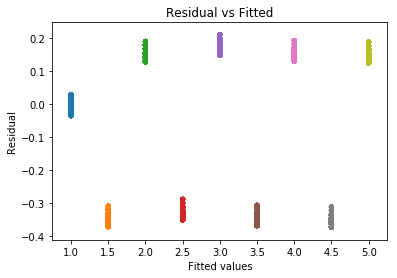

In [49]:
# Residuals vs fitted values
fig = plt.figure()
ax1 = sns.stripplot(train.Y, residual)
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residual')
ax1.set_title('Residual vs Fitted')

plt.show()

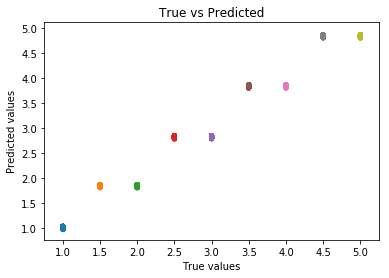

In [50]:
# True values vs predicted values
fig = plt.figure()
ax1 = sns.stripplot(test.Y, model.predict(test))
ax1.set_xlabel('True values')
ax1.set_ylabel('Predicted values')
ax1.set_title('True vs Predicted')

plt.show()

According to the plots above, the fitting model on the training set has roughly random residuals, and the prediction are satisfiable. Therefore, the model can be deemed to fit the data well.

### Model interpretation

The intercept of the model is 1.85, so a 0-99 level STEM course with no difficulty and poor professor averagely get 1.85 points in overall quality.

$X_1$ and $X_1^2$ are both significant , and their coefficients are negative, so generally students rate higher for an easier course; in the meanwhile, the more difficult a course is, the lower a course will be rated effect will be. And since the value of the coefficient is very small, this influence on course rating not strong.

The coefficients of the $X_2$ variables well coincide with their levels. Comparing to a poor rating professor, an average level one get about 1 point more, a good one get 2 points more, and an awesome professor can get 3 more points, and the aweful level professors get 0.84 points less.

And the in terms of the $X_3$ variables, the higher the level a course is, the more difficult a course can obtain a good rate. Also, since the  coefficients have relevant small values, this influence is not very strong.

Last, the STEM or non-STEM variable and its interaction with the difficulty level variable are dropped from the model. It indecates that there's no significant differences in overall quality between the rating of STEM courses and non-STEM courses.

#### Reference: Linear Regressions Using Statsmodels

https://underthecurve.github.io/jekyll/update/2016/07/01/one-regression-six-ways.html#Python

https://github.com/OpenNewsLabs/one-regression-six-ways/blob/master/Python/statsmodels_method.py

#### Reference: Forward selection
https://planspace.org/20150423-forward_selection_with_statsmodels/

## 4.5 KNN Regression

Except for the multiple linear regression model, we can also use machine learning methods fit the data. K Nearest Neighbor Regression is adopted here to produce a prediction on the testing set.

First we do a KNN Regrssion using number of neighbors = 3.

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics as skmetrics
import itertools

In [32]:
##KNN regression(k = 3)
from sklearn.neighbors import KNeighborsRegressor,kneighbors_graph

neigh = KNeighborsRegressor(n_neighbors = 3)
fit = neigh.fit(train.iloc[:,1:], train.Y)
pred = neigh.predict(test.iloc[:,1:])

In order to investigate how good the prediction is, although our response variable is a quantitative variable, it take the values of 1, 2, 3, 4, 5 or the midpoints in between. Consequently, we may take the closest integer of Y to know generally how good the prediction of overall quaity is. In this case, we can compute the confusion matrix to see how good the KNN method work.

### Confusion matrix

In [33]:
#Take the closest integer
#Take the closest integer
y_pred = round(pd.DataFrame(pred))
y_true = round(test.Y)

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 517    0    0    0    0]
 [   0  560  224    0    0]
 [   0   19  464    0    0]
 [   0    0    0 1089  614]
 [   0    0    0    0 1501]]


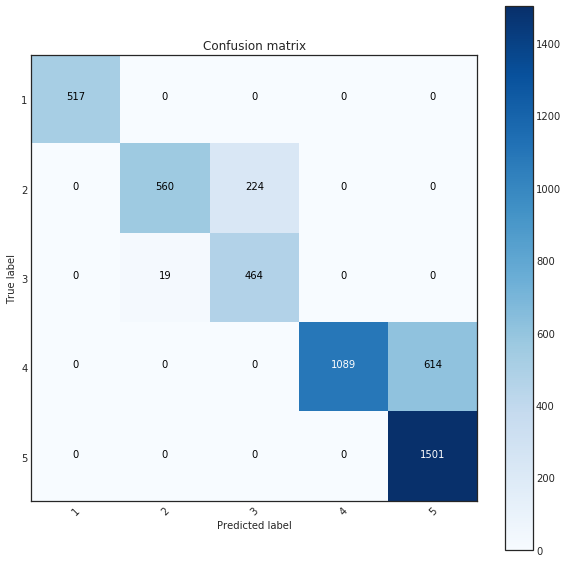

In [35]:
#Draw the confusion matrix
fig = plt.figure(figsize = (10,10))
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(confusion_matrix(y_true,y_pred),[1,2,3,4,5])
plt.show()

Normalized confusion matrix
[[1.         0.         0.         0.         0.        ]
 [0.         0.71428571 0.28571429 0.         0.        ]
 [0.         0.03933747 0.96066253 0.         0.        ]
 [0.         0.         0.         0.63945978 0.36054022]
 [0.         0.         0.         0.         1.        ]]


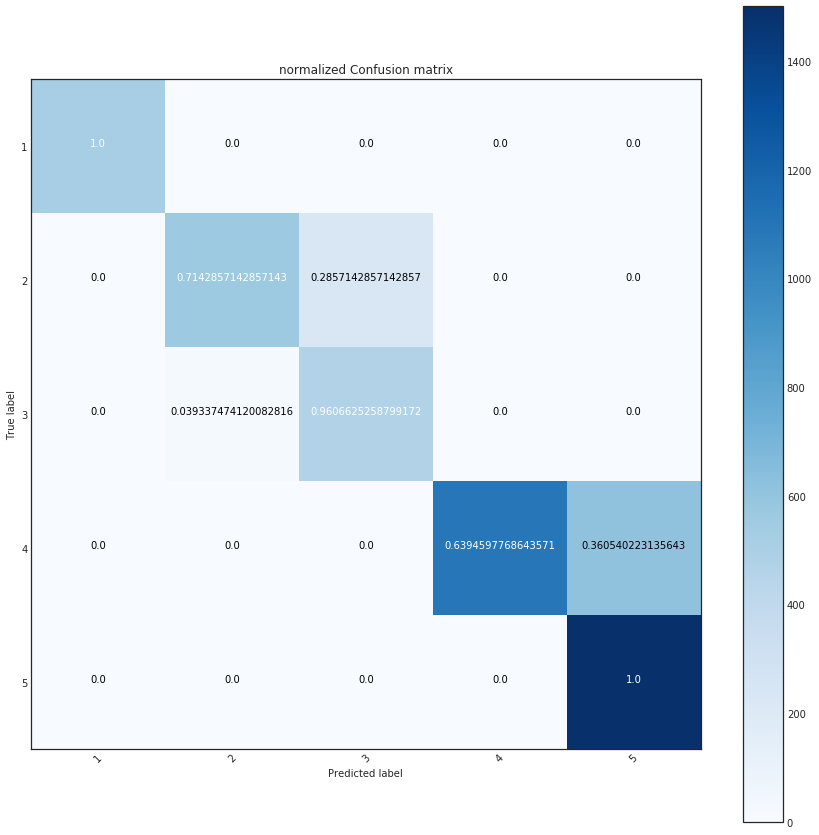

In [36]:
#Draw the normalized confusion matrix
fig = plt.figure(figsize = (15,15))
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(confusion_matrix(y_true,y_pred),[1,2,3,4,5],normalize = True, title = 'normalized Confusion matrix')
plt.show()

According to the normalized and unnormalized confusion matrices for KNN Regression (neighbors = 3), the prediction is quite good: when the true value of Overall Quality are 1, the prediction is perfect, and when Overall Quality is 3 and 5, the accuracies are also over 95%.

But still, we want to find a KNN Regression model with the number of neighbors that predict the model best. To evaluate the prediction, we introduce two criteria: prediction error(PE) and misclassification error.

$PE=(Y-\hat Y)^2$

$MR=$misclassification rate

In [37]:
#Prediction error
def prediction_error(k):
    """
    Compute the prediction error
    
    Arguments:
        k(integer): number of neighbors
        
    Returns:
        pe(float) = prediction error
    
    """
    
    neigh = KNeighborsRegressor(n_neighbors = k)
    fit = neigh.fit(train.iloc[:,1:], train.Y)
    
    pred = neigh.predict(test.iloc[:,1:])
    
    y = pd.DataFrame(test.Y).reset_index()
    yy = pd.concat([pd.DataFrame(pred),y],axis = 1)

    prede = [(yy.iloc[:,0][i] - yy.iloc[:,1][i])**2 for i in range(len(yy))]
    pe = sum(prede)

    return pe

In [38]:
#Compute prediction error
PE =[prediction_error(i) for i in range(1,21)]
k = [i for i in range(1,21)]

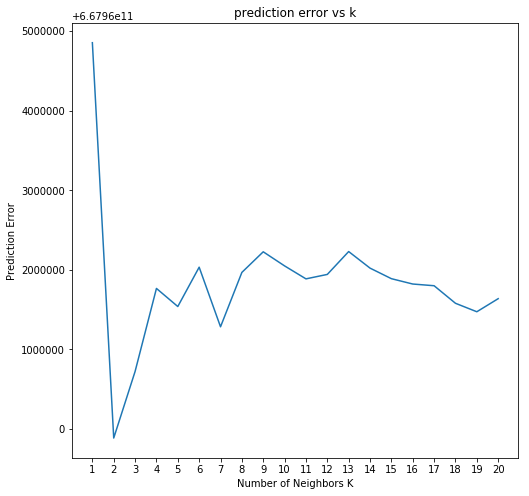

In [39]:
# plot prediction error vs k
fig = plt.figure(figsize = (8,8))
plt.plot(k,PE)

new_ticks = np.linspace(1, 20, 20)
plt.xticks(new_ticks)

plt.xlabel('Number of Neighbors K')
plt.ylabel('Prediction Error')
plt.title('prediction error vs k')

plt.show()

According to the prediction error vs k plot, we can see that when $k = 2$, the prediction error is relatively the smallest, and after 2, the prediction error somewhat increases to a level and keep unchanged when k is larger.

In [40]:
#Take the closest integer of Y and reindex
y_true = round(test.Y)
y_true = y_true.reset_index()

In [41]:
#Misclassification rate
def misclass_rate(k):
    """
    Compute the misclassification rate
    
    Arguments:
        k(integer): number of neighbors
        
    Returns:
        mr(float) = misclassification rate
    
    """
    neigh = KNeighborsRegressor(n_neighbors = k)
    fit = neigh.fit(train.iloc[:,1:], train.Y)
    
    pred = neigh.predict(test.iloc[:,1:])
    y_pred = round(pd.DataFrame(pred))
    
    yy = pd.concat([y_pred,y_true],axis = 1)

    ct = yy.iloc[:,0] - yy.iloc[:,2]
    count = 0
    for i in range(len(ct)):
        if ct[i] != 0:
            count = count + 1

    mr = count/len(ct)
    return mr

In [42]:
#Compute 1 - misclassification rate
CR =[1 - misclass_rate(i) for i in range(1,21)]

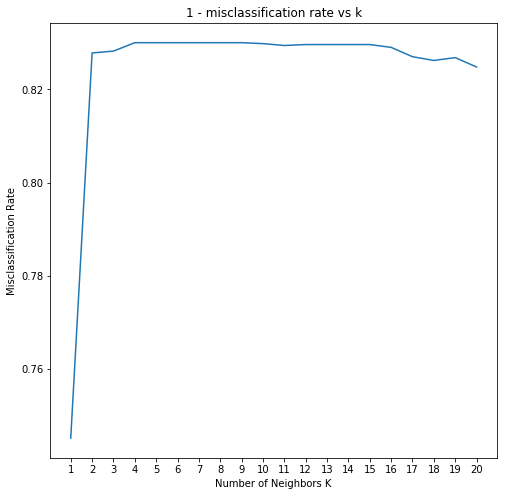

In [43]:
# plot 1 - misclassification rate vs k
fig = plt.figure(figsize = (8,8))
plt.plot(k,CR)

new_ticks = np.linspace(1, 20, 20)
plt.xticks(new_ticks)

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Rate')
plt.title('1 - misclassification rate vs k')

plt.show()

The 1 - misclassification rate vs k plot, 1 - misclassification rate surges after 1 and reaches a very high point at $k = 2$. It achieves the maximum at $k = 4$, and then starts to decrease slowly. So when $k\geq2$, the KNN regression produce roughly equivalent prediction on the testing set. The best predictiing rate is about 83%.

To combine the two criteria, the KNN Regression model with $k=2$ produce a best prediction in combination of prediction error and misclassification rate. The new fitting and confusion matrix is shown below.

In [44]:
##KNN regression(k = 2)
from sklearn.neighbors import KNeighborsRegressor,kneighbors_graph

neigh = KNeighborsRegressor(n_neighbors = 2)
fit = neigh.fit(train.iloc[:,1:], train.Y)
pred = neigh.predict(test.iloc[:,1:])

#Take the closest integer
y_pred = round(pd.DataFrame(pred))

#Take the closest integer
y_true = round(test.Y)

Confusion matrix, without normalization
[[ 517    0    0    0    0]
 [   0  565  219    0    0]
 [   0   26  457    0    0]
 [   0    0    0 1089  614]
 [   0    0    0    0 1501]]


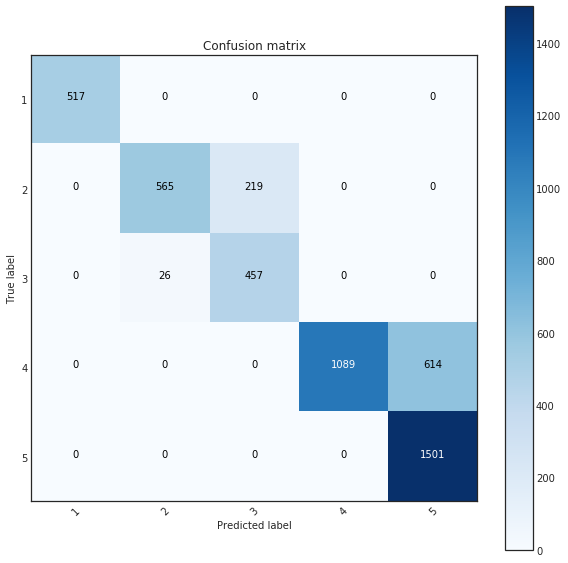

In [45]:
#Draw the confusion matrix
fig = plt.figure(figsize = (10,10))
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(confusion_matrix(y_true,y_pred),[1,2,3,4,5])
plt.show()

In [46]:
#Obtain the creteria for KNN Regression (k = 2)
print(PE[2])
print(CR[2])

667960722720.3066
0.8281876503608661


Therefore, the final model is obtained when $k = 2$, and it achieves the best prediction in terms of both accurate prediction and rough classification of Overall Quality of a course.

#### Reference: Confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

## 4.6 Analysis of Tags and Comments WordCloud

In [17]:
import numpy as np
import nltk
from textblob import TextBlob
import string

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(words):
    ttl = ' '.join(pd.Series(words))
    wordcloud1 = WordCloud().generate(ttl)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud1, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [56]:
# awesome and good tags
ag_cmt_tags = rmp[rmp['RatingType'].isin(['awesome','good'])]['comment tags']
print('The number of professors with awesome and good rating is',len(ag_cmt_tags))
ag_cmt_tags = ag_cmt_tags[ag_cmt_tags != "['']"]
ag_tags = []
for i in range(len(ag_cmt_tags)):
    ag_tags += re.findall(r"[A-Za-z\s]+", ag_cmt_tags.iloc[i])
ag_tags = [x for x in ag_tags if x != ' ']

# average tags
ave_cmt_tags = rmp[rmp['RatingType'] == 'average']['comment tags']
print('The number of professors with average rating is',len(ave_cmt_tags))
ave_cmt_tags = ave_cmt_tags[ave_cmt_tags != "['']"]
ave_tags = []
for i in range(len(ave_cmt_tags)):
    ave_tags += re.findall(r"[A-Za-z\s]+", ave_cmt_tags.iloc[i])
ave_tags = [x for x in ave_tags if x != ' ']

# poor and awful tags
praf_cmt_tags = rmp[rmp['RatingType'].isin(['poor', 'awful'])]['comment tags']
print('The number of professors with poor and awful rating is',len(ave_cmt_tags))
praf_cmt_tags = praf_cmt_tags[praf_cmt_tags != "['']"]
praf_tags = []
for i in range(len(praf_cmt_tags)):
    praf_tags += re.findall(r"[A-Za-z\s]+", praf_cmt_tags.iloc[i])
praf_tags = [x for x in praf_tags if x != ' ']

The number of professors with awesome and good rating is 12753
The number of professors with average rating is 2910
The number of professors with poor and awful rating is 1013


#### 4.6.1 Word Cloud Analysis

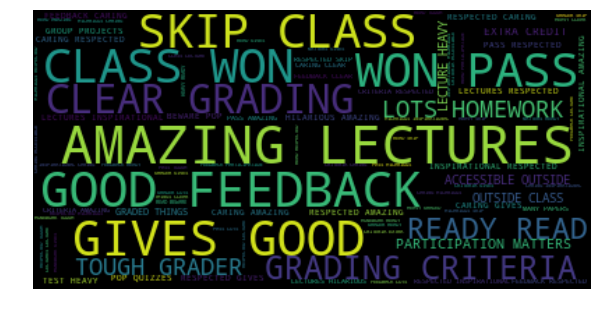

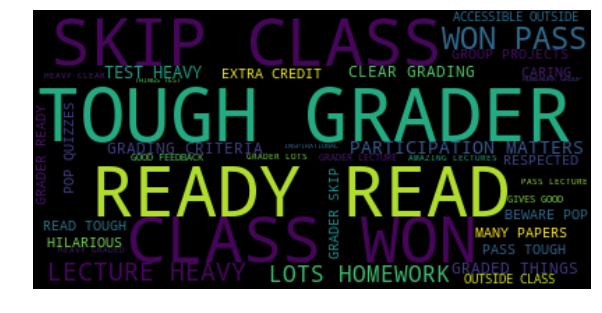

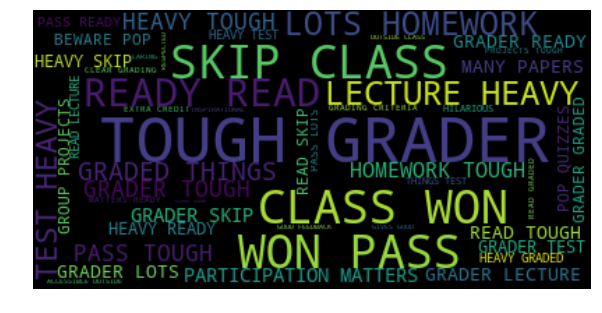

In [57]:
wordcloud(ag_tags)
wordcloud(ave_tags)
wordcloud(praf_tags)

__Conclusion of comment tags:__

Students select tags they think can best describe professors (also courses). Through Word Cloud, we can have a rough impression on the most frequent words and phrases, which also demonstrate what students do really care about when evaluating a professor and what kind of features are able to satisfy students' demands on studying. 

Viewing the above three Word Clouds referring to __`'awesome & good'`__, __`'average'`__, and __`'poor & awful'`__ in order, it is apparent that for the professor with a higher rating, `"AMAZING LECTURES"`, `"GIVES GOOD FEEDBACK"`, `"CLEAR GRADING CRITERIA"` are most common phrases, also `"ACCESSIBLE OUTSIDE"` is one of phrases very different from ratings in other levels. For the professor with an average or lower rating, `"TOUGH GRADER"`, `"SKIP CLASS? YOU WON'T PASS"`, `"GET READY TO READ"`, `"HOMEWORK TOUGH"`, `"LOTS HOMEWORK"`, and `"LECTURE HEAVY"` are the most frequent phrases. As for the difference between __`'average'`__ and __`'lower'`__ levels, more words related to __`"Grade"`__ show up at the lower levels, such as `"GRDED THINGS"`, `"GRADER TOUGH"`.

In [18]:
from nltk.corpus import stopwords

# add pronounciation into stopwords
stopwords = stopwords.words("english")+['“',"’",'”',"—",'‘','course',
                                        "n't", 'lecture', 'class', 'one', 'really', 'make', 'take', 's', 'get', 'professor']

from nltk.corpus import wordnet
from operator import itemgetter

def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

In [36]:
ag_cmt = rmp[rmp['RatingType'].isin(['awesome','good'])]['comment'].str.cat(sep=' ')
ag_blob = TextBlob(ag_cmt)
new_text = " ".join(w.lower() for w in ag_blob.words if w.lower() not in stopwords)
ag_blob = TextBlob(new_text)

ag_tags = [wordnet_pos(x[1]) for x in ag_blob.pos_tags]
ag_text = " ".join(x.lemmatize(t) for x, t in zip(ag_blob.words, ag_tags))
ag_blob = TextBlob(ag_text)
ag_dict = dict(ag_blob.word_counts)

In [37]:
ag_sort = sorted(ag_dict.items(), key=itemgetter(1), reverse=True)

sort_ag = []
for i in range(len(ag_sort)):
    if ag_sort[i][0] not in stopwords:
        sort_ag.append(ag_sort[i])
        
sort_ag[:10]

[('easy', 3381),
 ('great', 3065),
 ('good', 2813),
 ('lot', 2554),
 ('test', 2228),
 ('final', 2136),
 ('hard', 2119),
 ('material', 2024),
 ('go', 2009),
 ('helpful', 1957)]

In [38]:
ave_cmt = rmp[rmp['RatingType']== 'average']['comment'].str.cat(sep=' ')
ave_blob = TextBlob(ave_cmt)
new_text = " ".join(w.lower() for w in ave_blob.words if w.lower() not in stopwords)
ave_blob = TextBlob(new_text)

ave_tags = [wordnet_pos(x[1]) for x in ave_blob.pos_tags]
ave_text = " ".join(x.lemmatize(t) for x, t in zip(ave_blob.words, ave_tags))
ave_blob = TextBlob(ave_text)
ave_dict = dict(ave_blob.word_counts)

In [39]:
ave_sort = sorted(ave_dict.items(), key=itemgetter(1), reverse=True)

sort_ave = []
for i in range(len(ave_sort)):
    if ave_sort[i][0] not in stopwords:
        sort_ave.append(ave_sort[i])
        
sort_ave[:10]

[('hard', 937),
 ('easy', 717),
 ('test', 671),
 ('final', 594),
 ('lot', 588),
 ('grade', 564),
 ('good', 537),
 ('time', 493),
 ('material', 477),
 ('midterm', 469)]

In [40]:
praf_cmt = rmp[rmp['RatingType'].isin(['poor','awful'])]['comment'].str.cat(sep=' ')
praf_blob = TextBlob(praf_cmt)
new_text = " ".join(w.lower() for w in praf_blob.words if w.lower() not in stopwords)
praf_blob = TextBlob(new_text)

praf_tags = [wordnet_pos(x[1]) for x in praf_blob.pos_tags]
praf_text = " ".join(x.lemmatize(t) for x, t in zip(praf_blob.words, praf_tags))
praf_blob = TextBlob(praf_text)
praf_dict = dict(praf_blob.word_counts)

In [45]:
praf_sort = sorted(praf_dict.items(), key=itemgetter(1), reverse=True)

sort_praf = []
for i in range(len(praf_sort)):
    if praf_sort[i][0] not in stopwords:
        sort_praf.append(praf_sort[i])
        
sort_praf[:10]

[('hard', 979),
 ('test', 873),
 ('grade', 779),
 ('time', 670),
 ('like', 652),
 ('final', 647),
 ('go', 610),
 ('good', 596),
 ('material', 570),
 ('teach', 564)]

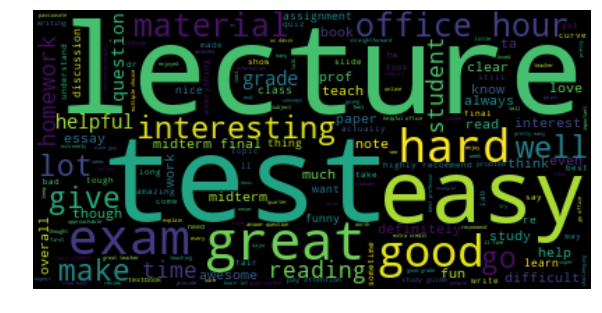

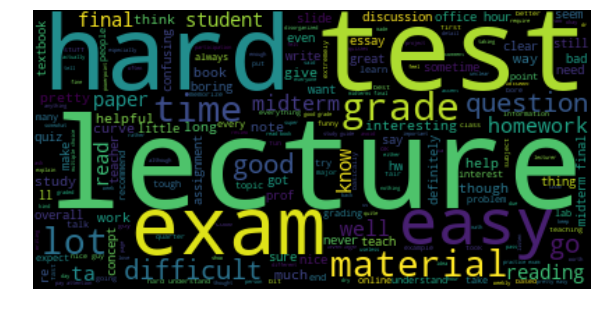

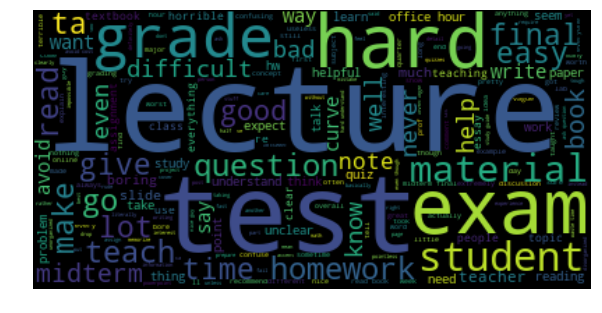

In [23]:
wordcloud(ag_text)
wordcloud(ave_text)
wordcloud(praf_text)

## 4.7 Conclusion

Professors, as the core of courses, are the most important part for us to play with statistical and machine learning tools. After scraping more than $20,000$ raw data from __`'Rating My Professors'`__ website, we complete data processing, exploratory data analysis and apply multiple linear regression and KNN regression to it. Finally, we get the following conclusions:

* The multiple linear regression model shows that the overall quality of a course can be predicted by the level of difficulty, rating type of professor and course level, while uncorrelated with that fact that whether it is a STEM course. Generally, an easier and lower degree course taught by a highly rating professor achieves a better overall quality in the rate_my_professor data.

* The overall quality can also be fitted by a KNN Regression model. Under the criteria of prediction error and misclassification rate, a KNN Regression model with $k=2$ perform best in prediction, with about 83% courses predicted right.

Another amazing data we collected are comment tags students selected and comments they wrote to best describe professors. Through Natural Language Processing (NLP), we figure out the most common words and phrases students used. In other words, we find out the important parts students care about, which can be summarized as the following:

* `"AMAZING LECTURES"`, `"GIVES GOOD FEEDBACK"`, `"CLEAR GRADING CRITERIA"` are most common characters of professors with a high rating, also `"ACCESSIBLE OUTSIDE"` is the one deserved to be emphasized.

* For average and lower ratings, words related to `"GRADE"` show a lot, `"HEAVY/TOUGH HOWEWORk/EXAM"` is a majority as well. This demonstrates that students are concerned about grades, which is really reasonable that a lower grade probably has a negative impact on students' impression of professors/courses.